In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
import os
import skimage.io
import caffe
caffe.set_mode_gpu()

from PIL import Image, ImageChops, ImageEnhance
import visualisation
import excitation_backprop
import debug
import beoid

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
spatial_conv1_1_filters_beoid = Image.open('./spatial_beoid_conv1_1_filters.png').convert('RGB')
spatial_conv1_1_filters_ucf101 = Image.open('./spatial_ucf101_conv1_1_filters.png').convert('RGB')

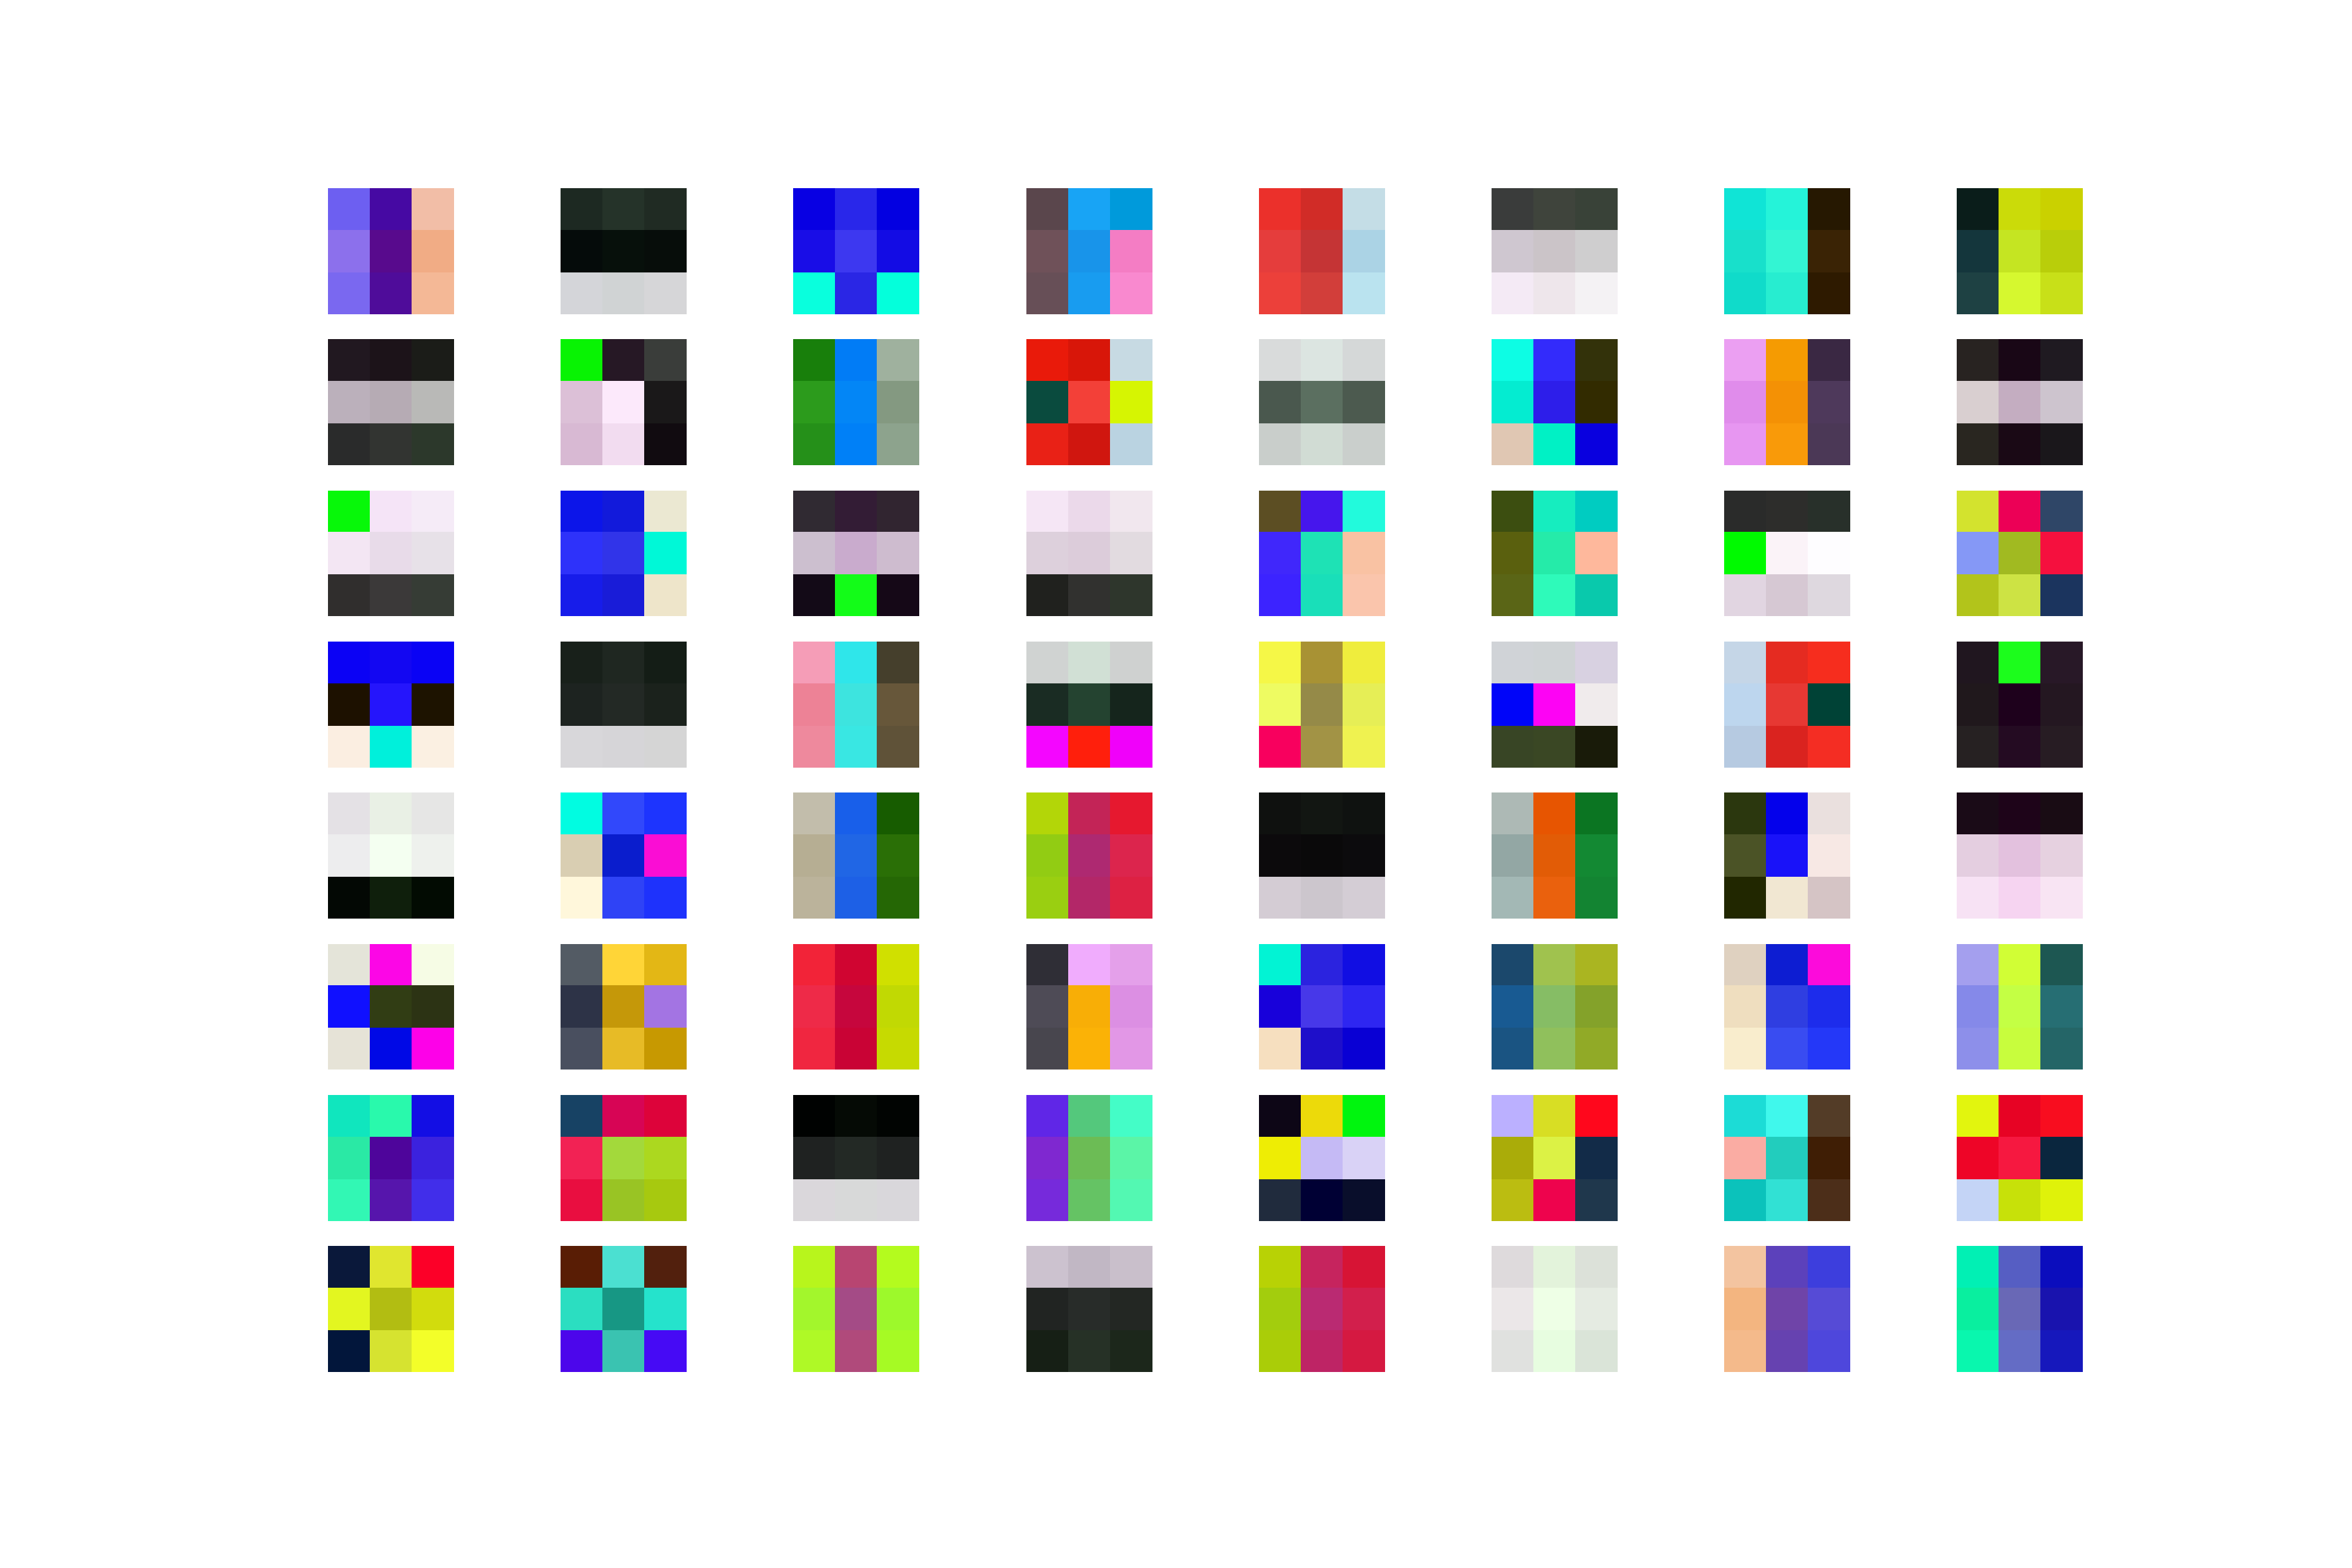

In [79]:
spatial_conv1_1_filters_beoid

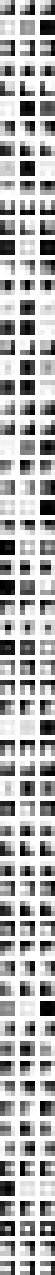

In [80]:
spatial_conv1_1_filters_ucf101

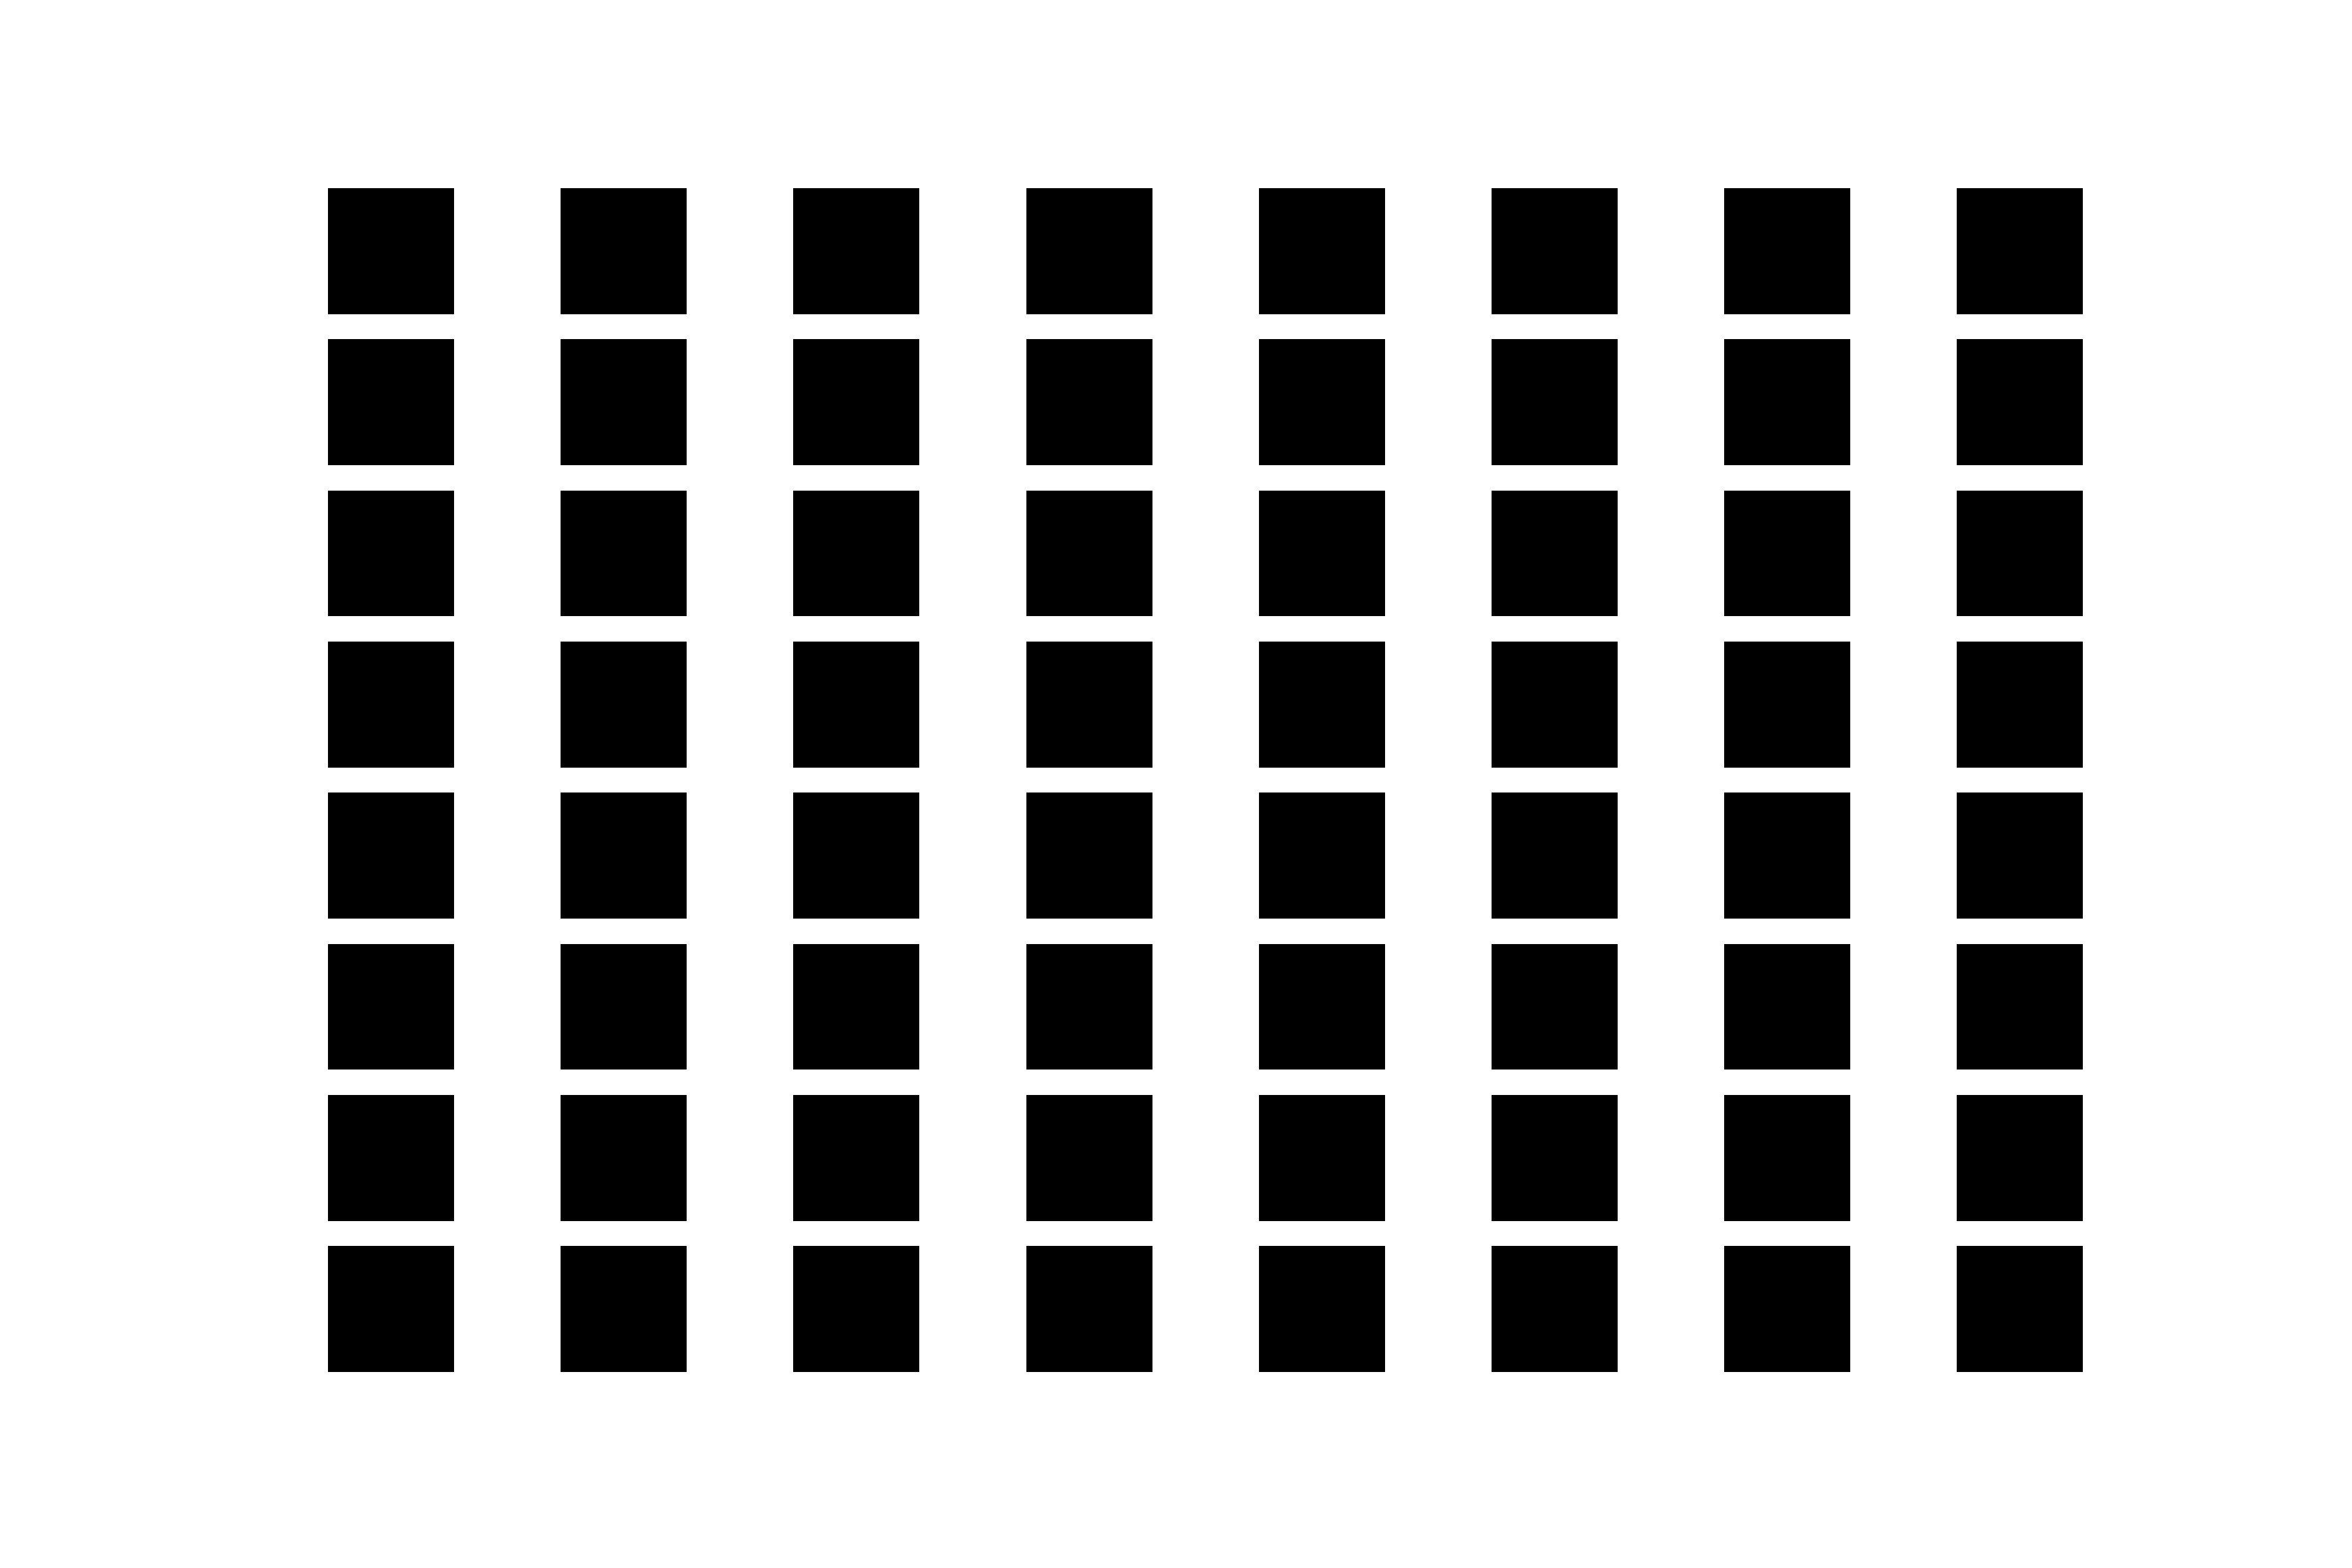

In [81]:
# We assume none of the kernel components are 255
spatial_conv1_1_mask = spatial_conv1_1_filters_beoid.convert('L').point(lambda x: 0 if x < 254 else 255)
spatial_conv1_1_mask

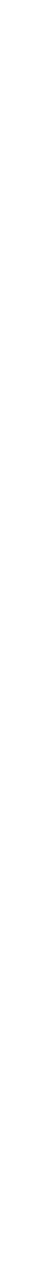

In [82]:
def diff_spatial(img1, img2, mask):
    diff = ImageChops.difference(img1, img2)
    diff = ImageChops.add(diff, mask.convert('RGB'))
    return diff

diff = diff_spatial(spatial_conv1_1_filters_beoid, spatial_conv1_1_filters_ucf101, spatial_conv1_1_mask)
diff.save('vgg16-spatial-beoid-ucf101-diff-filters-conv1_1.png')
diff

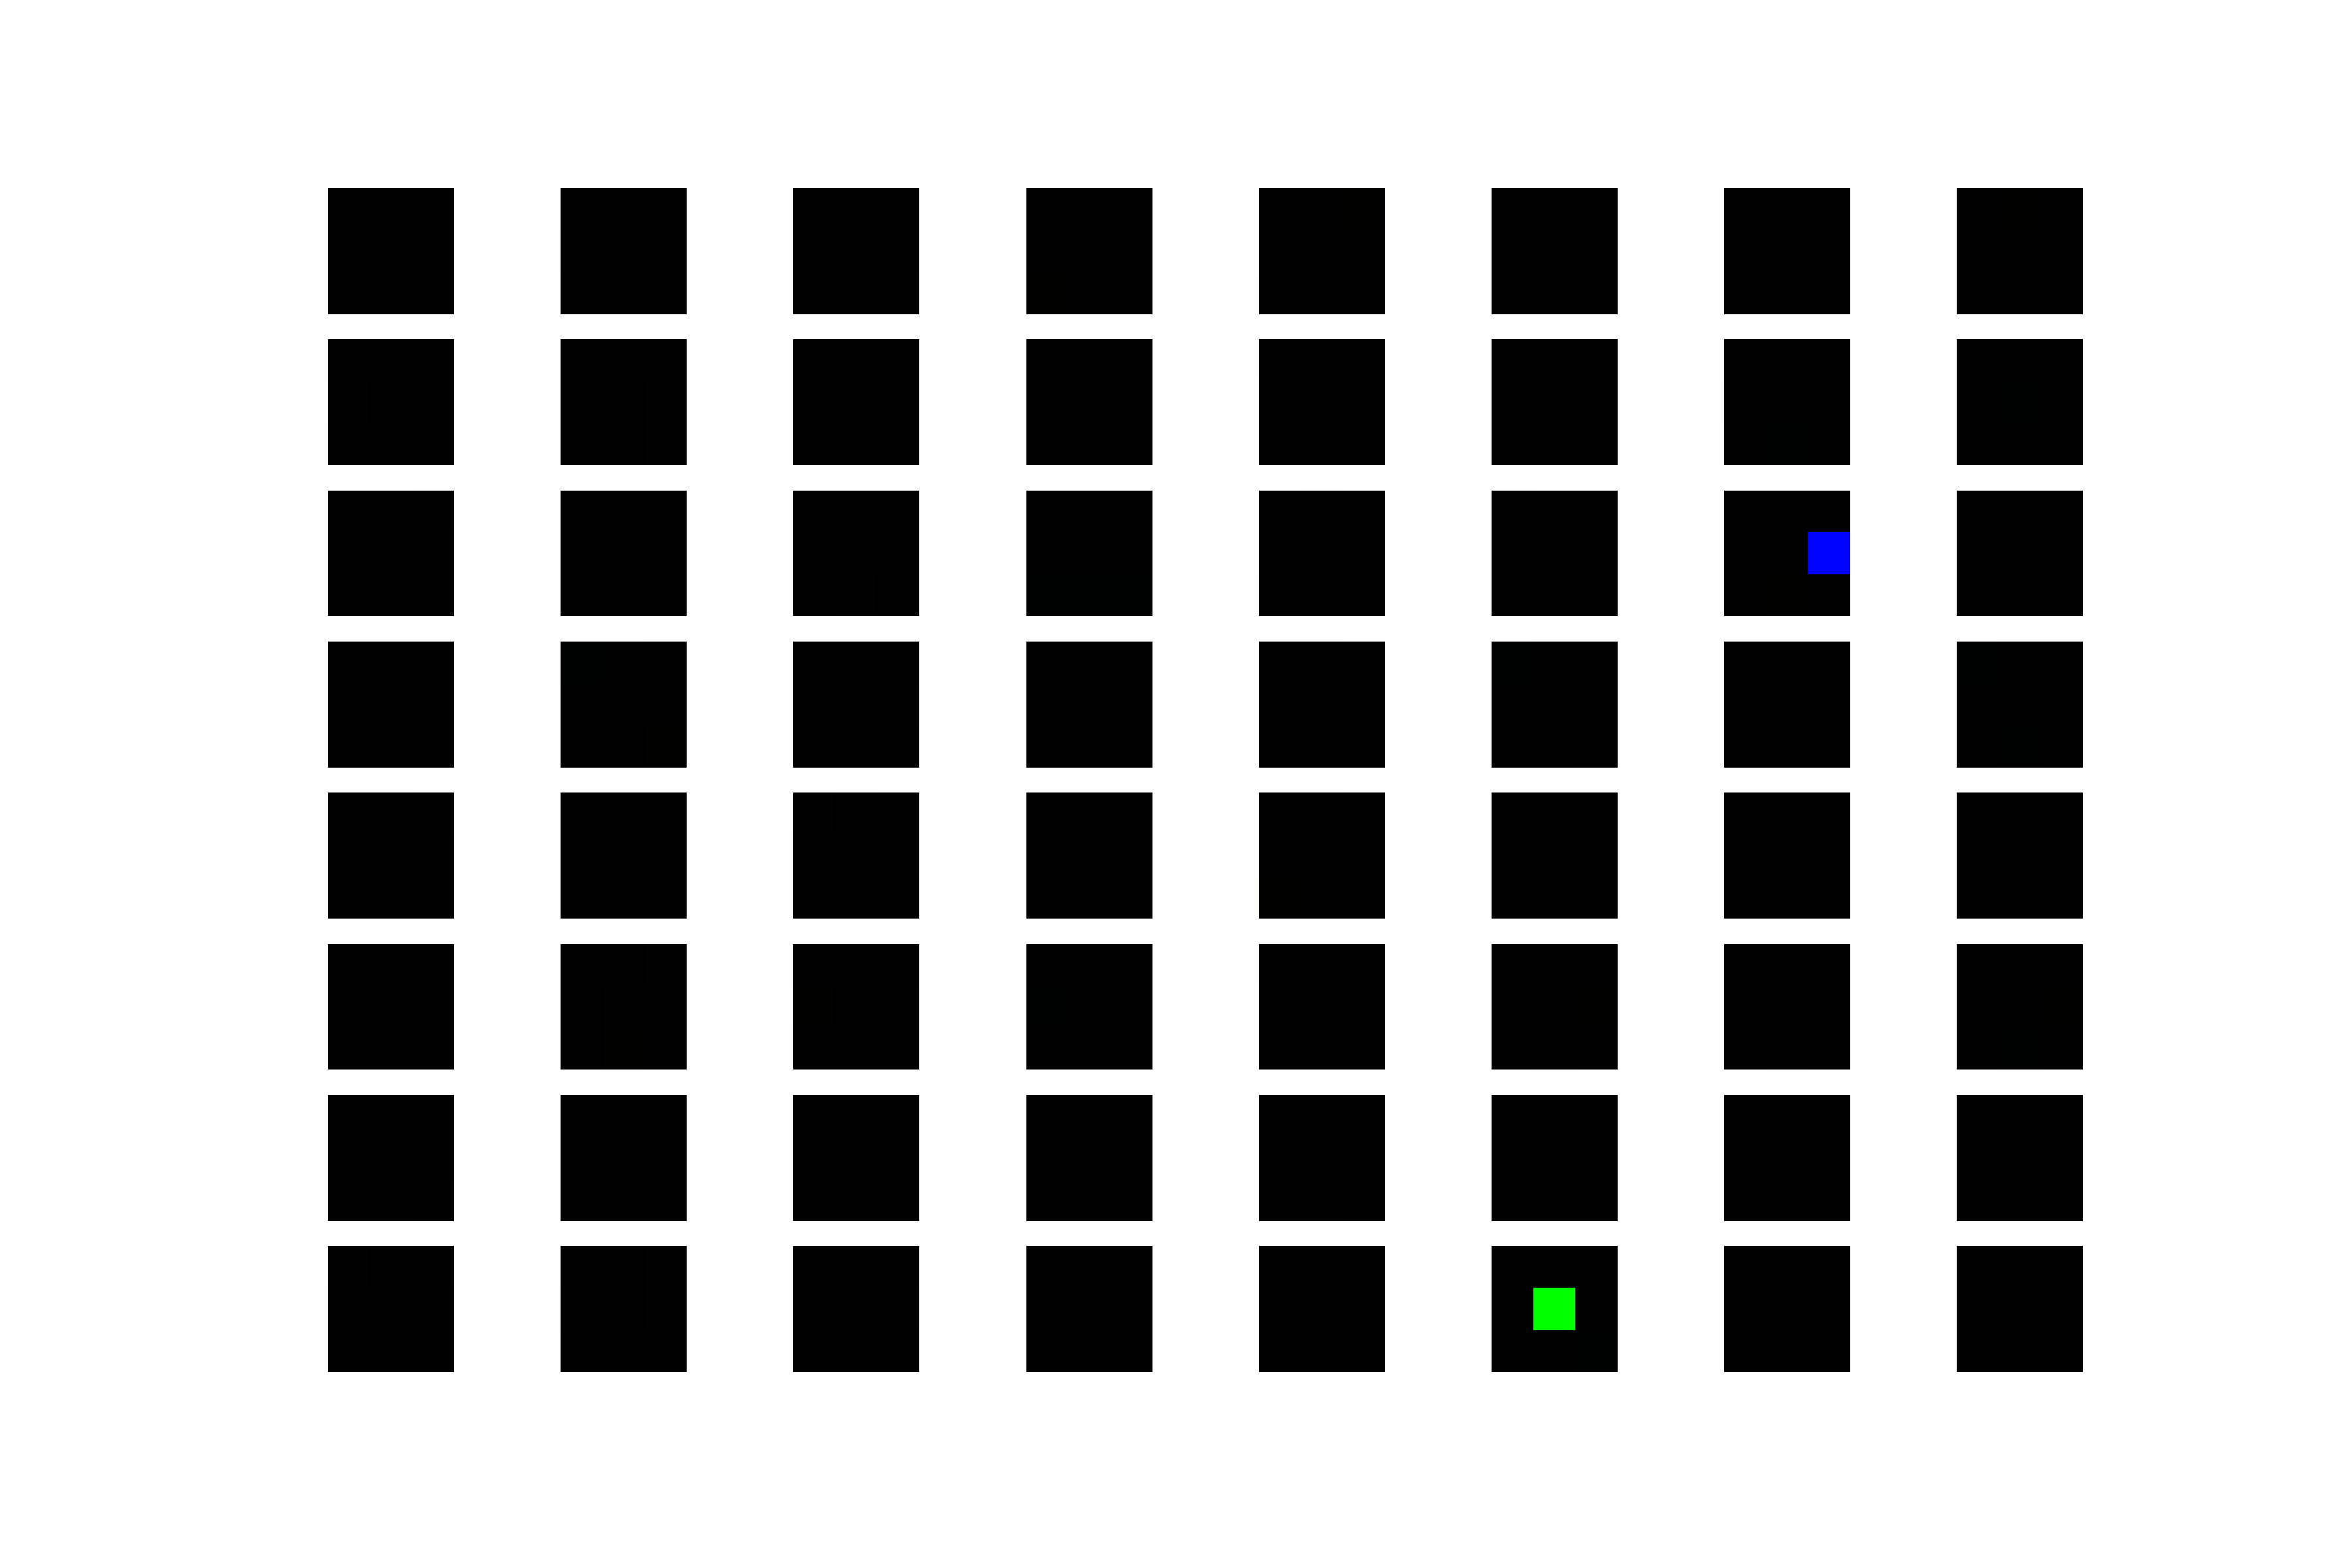

In [90]:
vgg_16_conv1_1_filters_imagenet = Image.open('./vgg-16_imagenet_conv1_1_filters.png').convert('RGB')
diff = diff_spatial(spatial_conv1_1_filters_beoid, vgg_16_conv1_1_filters_imagenet, spatial_conv1_1_mask)
diff.save('vgg-16_spatial_beoid_imagenet_conv1_1_filters_diff.png')
diff

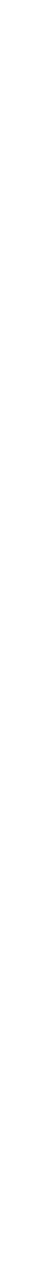

In [91]:
diff = diff_spatial(spatial_conv1_1_filters_ucf101, vgg_16_conv1_1_filters_imagenet, spatial_conv1_1_mask)
diff.save('vgg-16_spatial_ucf101_imagenet_conv1_1_filters_diff.png')
diff

In [92]:
nets = ['spatial', 'temporal']
datasets = ['ucf101', 'beoid']

block_configurations = [(block, block_id) for block, block_limit in [(1, 2), (2, 2), (3, 3), (4, 3), (5, 3)]
                                          for block_id in range(1, block_limit + 1)]
conv_layers = ["conv{}_{}".format(block, block_id) for block, block_id in block_configurations]
conv_layers

['conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3']

In [93]:
import ucf101_spatial_config
import ucf101_temporal_config
import beoid_spatial_config
import beoid_temporal_config

net_configs = {
    "vgg16-spatial": {
         "ucf101": ucf101_spatial_config,
        "beoid": beoid_spatial_config,
    },
    "vgg16-temporal": {
        "ucf101": ucf101_temporal_config,
        "beoid": beoid_temporal_config,
    }
}

datasets = ["ucf101", "beoid"]
architectures = ["vgg16-spatial", "vgg16-temporal"]

nets = {}
for architecture, net_configs in net_configs.items():
    nets[architecture] = {}
    for dataset, config in net_configs.items():
        nets[architecture][dataset] = caffe.Net(config.net_prototxt_path, 
                                               config.net_caffemodel_path, 
                                               caffe.TEST)

In [94]:
def weights(net, layer):
    return net.params[layer][0].data

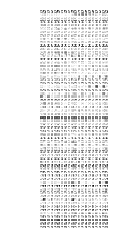

In [97]:
from scipy.misc import toimage
layer = 'conv1_1'
temporal_conv1_1_diff = np.abs(
    weights(nets['vgg16-temporal']['ucf101'], layer) - \
    weights(nets['vgg16-temporal']['beoid'], layer)
)
temporal_conv1_1_diff = temporal_conv1_1_diff.max() - temporal_conv1_1_diff 

temporal_conv1_1_diff_vis = visualisation.show_grayscale_filters_from_weights(
    temporal_conv1_1_diff, scaling_method=visualisation.SCALING_METHODS.LAYER)

plt.clf()
plt.imshow(temporal_conv1_1_diff_vis, cmap='gray')
plt.axis('off')
plt.savefig('temporal_conv1_1_diff_vis.pdf')
plt.show()

In [ ]:
for architecture, nets_for_stream in nets.items():
    for conv_layer in conv_layers:
        filename = '{}_{}_ucf101_beoid_filters_diff.png'.format(architecture, conv_layer)
        print("Generating {}".format(filename))
        weight_diff = weights(nets_for_stream["ucf101"], conv_layer) - weights(nets_for_stream["beoid"], conv_layer)
        weights_diff_vis = visualisation.show_grayscale_filters_from_weights(weight_diff, scaling_method=visualisation.SCALING_METHODS.KERNEL)
        toimage(weights_diff_vis).save(filename)